In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers, losses, metrics

import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
EPOCHS = 30
BATCH_SIZE = 128
ETA = 1e-2

In [3]:
trainset, testset = mnist.load_data()

In [4]:
trainloader = tf.data.Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(1024)
testloader = tf.data.Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

In [5]:
def preprocessing(x):
    x = tf.reshape(x, shape=(-1, 784))
    x = tf.cast(x, dtype=tf.float32)
    x /= 256
    return x

In [28]:
class RBM(models.Model):
    
    def __init__(self):
        super(RBM, self).__init__()
        
        self.W = tf.Variable(tf.random.normal((784, 32)), name="W")
        self.b = tf.Variable(tf.random.normal((1, 32)), name="b")
        self.c = tf.Variable(tf.random.normal((1, 784)), name="c")
        
    def call(self, v0):
        h0_given_v0 = self._h_given_v(v0)
        h0 = self._sample(h0_given_v0)
        v1_given_h0 = self._v_given_h(h0)
        v1 = self._sample(v1_given_h0)
        return v1, v1_given_h0
    
    def _h_given_v(self, v):
        logit = tf.matmul(v, self.W) + self.b
        h_given_v = tf.nn.sigmoid(logit)
        return h_given_v
    
    def _v_given_h(self, h):
        logit = tf.matmul(h, tf.transpose(self.W, (1, 0))) + self.c
        v_given_h = tf.nn.sigmoid(logit)
        return v_given_h
    
    def _sample(self, prob):
        r = tf.random.uniform(tf.shape(prob), minval=0, maxval=1)
        sample = tf.where(r < prob, 1.0, 0.0)
        return sample
    
    def _compute_free_energy(self, v):
        logit = tf.matmul(v, self.W) + self.b
        free_energy = -tf.matmul(v, tf.transpose(self.c, (1, 0))) - tf.reduce_sum(tf.nn.softplus(logit), axis=-1)
        return free_energy
    
    def compute_fake_loss(self, v0, v1):
        F0 = self._compute_free_energy(v0)
        F1 = self._compute_free_energy(v1)
        fake_loss = F0 - F1
        return fake_loss
    
    def compute_display_loss(self, v0, v1):
        return tf.reduce_mean((v0 - v1)**2)
    
    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self.get_weights(), f)
            
    def load(self, path):
        with open(path, "rb") as f:
            data = pickle.load(f)
            self.set_weights(data)


In [29]:
def train_step(model, x, y, optimizer):
    v0 = preprocessing(x)
            
    with tf.GradientTape() as tape:
        v1, _ = model(v0)
        loss = model.compute_fake_loss(v0, v1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    display_loss = model.compute_display_loss(v0, v1)
    return display_loss

In [30]:
def test_step(model, x, y):
    v0 = preprocessing(x)
            
    v1, _ = model(v0)
    display_loss = model.compute_display_loss(v0, v1)

    return display_loss

In [31]:
def train():
    model = RBM()
    optimizer = optimizers.Adam(learning_rate=ETA)
    train_loss = metrics.Mean()
    test_loss = metrics.Mean()
    
    train_loss_list = []
    test_loss_list = []
    
    for e in range(EPOCHS):
        for x, y in trainloader:
            loss = train_step(model, x, y, optimizer)
            train_loss.update_state(loss)
            
        for x, y in testloader:
            loss = test_step(model, x, y)
            test_loss.update_state(loss)
            
        train_ls = train_loss.result()
        train_loss_list.append(train_ls)
        
        test_ls = test_loss.result()
        test_loss_list.append(test_ls)
            
        print(f"Epochs {e+1}/{EPOCHS}, train loss: {train_ls:.8f}, test loss: {test_ls:.8f}")
        
        
        train_loss.reset_states()
        test_loss.reset_states()
        
    model.save("ckpts/rbm.bin")
    
    return train_loss_list, test_loss_list

In [34]:
def plot():
    model = RBM()
    model.build(input_shape=(None, 784))
    model.load("ckpts/rbm.bin")
    
    x, y = next(iter(testloader))
    v0 = preprocessing(x)
    _, v1 = model(v0)
    
    x0 = x.numpy().reshape(-1, 28, 28)
    x1 = v1.numpy().reshape(-1, 28, 28)
    
    print("Original image:")
    plt.figure(figsize=(12, 12), dpi=120)
    
    for i in range(16):
        img0 = x0[i]
        
        plt.subplot(4, 4, i+1)
        plt.imshow(img0)
        
    plt.show()
    
    print("Reconstructed image:")
    plt.figure(figsize=(12, 12), dpi=120)
    
    for i in range(16):
        img1 = x1[i]
        
        plt.subplot(4, 4, i+1)
        plt.imshow(img1)
        
    plt.show()

In [33]:
train_loss_list, test_loss_list = train()

Epochs 1/30, train loss: 0.19274274, test loss: 0.11933049
Epochs 2/30, train loss: 0.10976194, test loss: 0.10462257
Epochs 3/30, train loss: 0.10345713, test loss: 0.10112629
Epochs 4/30, train loss: 0.10129967, test loss: 0.10073570
Epochs 5/30, train loss: 0.09997612, test loss: 0.09887270
Epochs 6/30, train loss: 0.09839740, test loss: 0.09700014
Epochs 7/30, train loss: 0.09718368, test loss: 0.09614462
Epochs 8/30, train loss: 0.09640788, test loss: 0.09589816
Epochs 9/30, train loss: 0.09585442, test loss: 0.09570997
Epochs 10/30, train loss: 0.09517015, test loss: 0.09430889
Epochs 11/30, train loss: 0.09434200, test loss: 0.09399841
Epochs 12/30, train loss: 0.09364839, test loss: 0.09269997
Epochs 13/30, train loss: 0.09285083, test loss: 0.09252871
Epochs 14/30, train loss: 0.09205642, test loss: 0.09130174
Epochs 15/30, train loss: 0.09104606, test loss: 0.09056231
Epochs 16/30, train loss: 0.09040602, test loss: 0.09047871
Epochs 17/30, train loss: 0.08989733, test loss: 

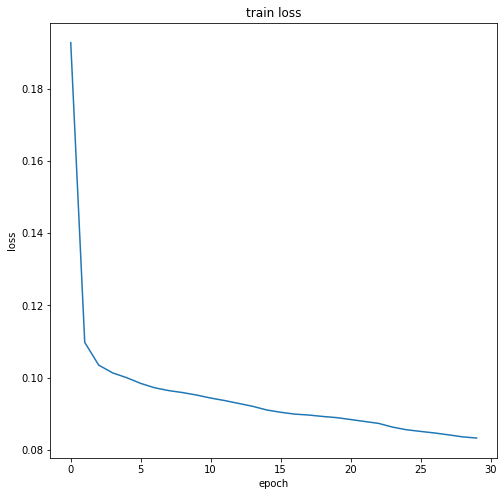

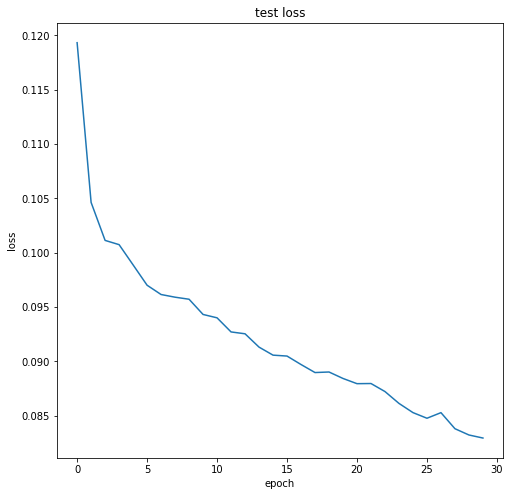

In [35]:
plt.figure(figsize=(8, 8))
plt.plot(train_loss_list)
plt.title("train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(test_loss_list)
plt.title("test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Original image:


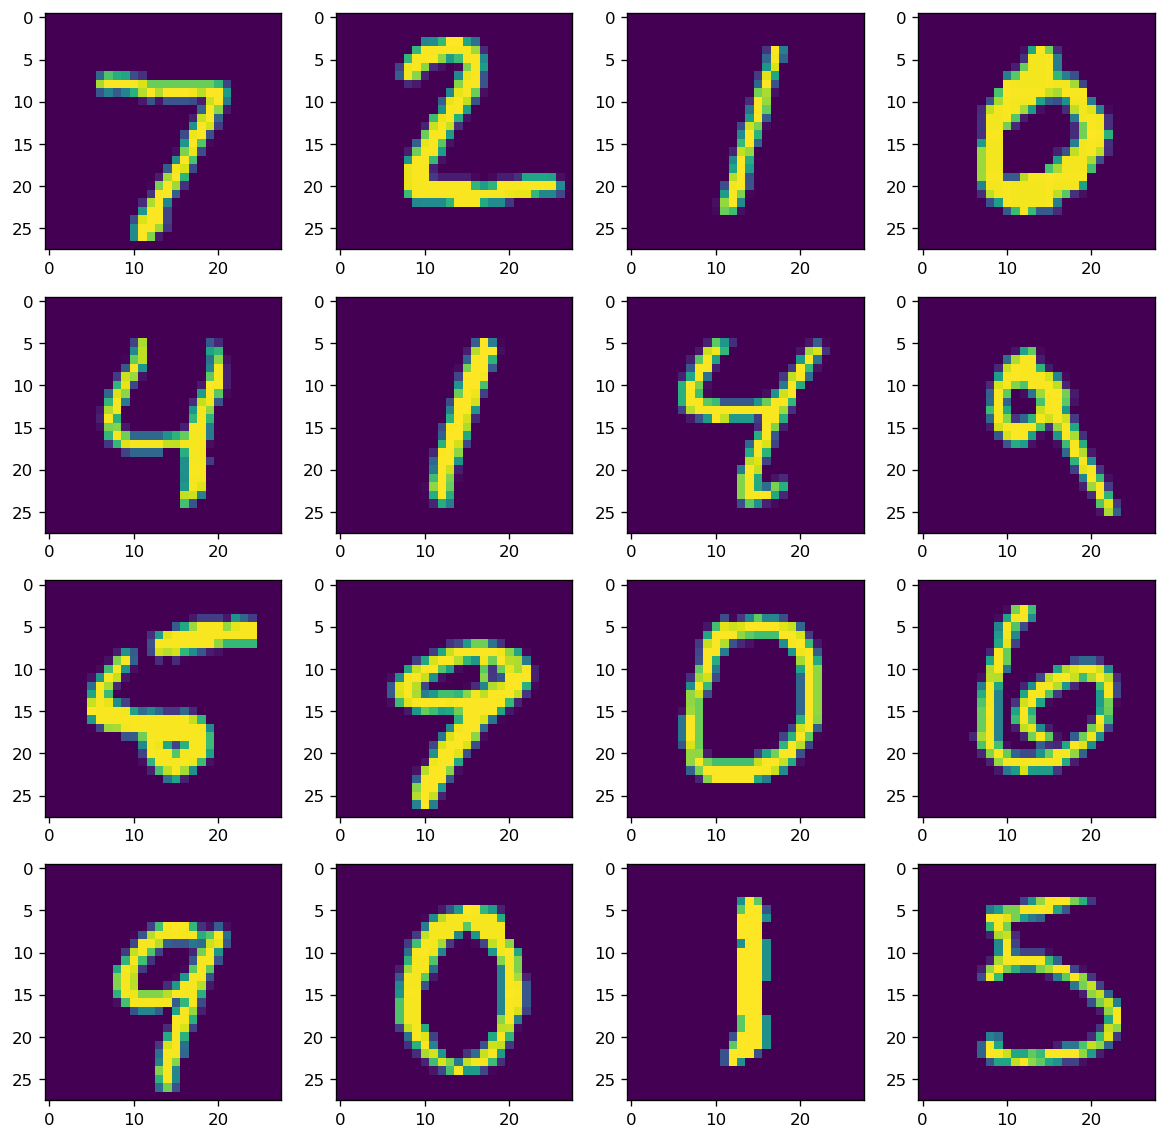

Reconstructed image:


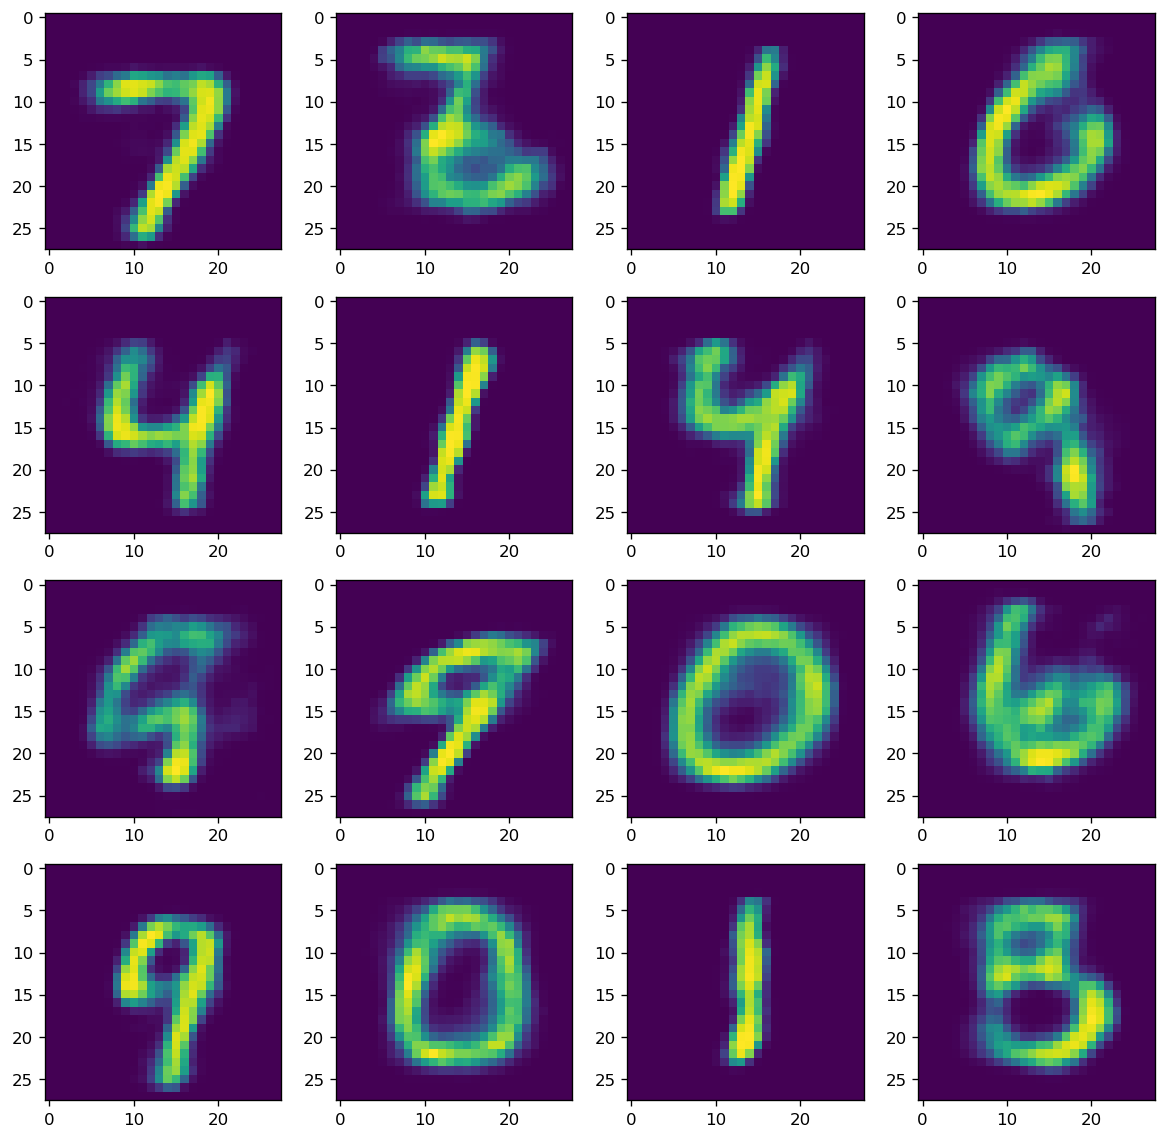

In [36]:
plot()